<a href="https://colab.research.google.com/github/AuraFrizzati/NHSW-NHFD-Web-Scraper/blob/main/NHSWales_webscraper_NHFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NHFD web scraper**
Script to web scrape Hip Fracture data from the National Hip Fracture Database (NHFD) (https://www.nhfd.co.uk/)

## **[0] Import libraries, define the base pathway where files are downloaded and the list of hospitals of interest, session retry strategy**

Please press play in the cell below:

In [ ]:
## Import relevant libraries:
from google.colab import drive
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import pytz
import os
import re
from requests.adapters import HTTPAdapter
from urllib3.util import Retry

# Define the path to the directory where your folders are located
base_path = '/content/'

# Hospital sites of interest
site_list = [
  "[ALL]",
  "[England]",
  "[Wales]",
  "[NI]",
  "BRG",
  "CLW",
  "GWE",
  "GWY",
  "MOR",
  "PCH",
  "POW",
  "RGH",
  "UHW",
  "WRX",
  "WWG",
  "WYB"
  ]


# Define the retry strategy
# https://www.zenrows.com/blog/python-requests-retry#status-codes
retry_strategy = Retry(
    total=4,  # Maximum number of retries
    status_forcelist=[429, ## Too Many Requests
                      500, ## Internal Server Error
                      502, ## 502 Bad Gateway
                      503, ## 503 Service Unavailable
                      504 ## 504 Gateway Timeout
                      ],  # HTTP status codes to retry on
)
# Create an HTTP adapter with the retry strategy and mount it to session
adapter = HTTPAdapter(max_retries=retry_strategy)

print("this cell has run successfully, you can proceed :)")


## **[1] Webscrape Denoms (denominators)**
Please press play in the cell below:

In [ ]:
### [1a] Webscrape Denoms
sentences_list = []
month_end_list = []
cases_list = []
k0_list = []
k1_list = []
k2_list = []
k3_list = []
k4_list = []
k5_list = []
k6_list = []
k7_list = []

date_of_scrape = datetime.now(pytz.timezone("Europe/London"))
date_of_scrape = date_of_scrape.strftime("%Y-%m-%d %H:%M:%S")

# Create a new session object
session = requests.Session()
session.mount('https://', adapter)


print('webscrape_Denoms started')

for x in site_list:
    # Make outgoing HTTP Request
    url = f"https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIsOverview?open&org={x}"

    # Results Object
    result = session.get(
        url,
        headers={'User-Agent': 'Mozilla/5.0'}
        #, verify=False ## SSL certificate issue
        )

    ## Parse Content of Results Object
    doc = BeautifulSoup(result.text, "html.parser")

    # [1] find the descriptive text in the html code
    # e.g. "Annualised values based on 70,617 cases averaged over 12 months.."
    sentence = doc.find_all('div', {'class': 'note'})[0].text.replace('\n', '')
    sentences_list.append(sentence)

    # [2] find the KPI numeric data in the html code
    data = doc.find_all('div', {'class': 'annual'})
    kpi_data = []

    for i in data:
        kpi_data.append(i.text)

    # [3] Create lists by KPI type
    k0_list.append(kpi_data[0])
    k1_list.append(kpi_data[1])
    k2_list.append(kpi_data[2])
    k3_list.append(kpi_data[3])
    k4_list.append(kpi_data[4])
    k5_list.append(kpi_data[5])
    k6_list.append(kpi_data[6])
    k7_list.append(kpi_data[7])

    # [4] Extract Month and Year from descriptive text webscraped in [1]

    # Look for one or more word characters `(\w+)`, followed by one or more whitespaces `\s+`,
    # followed by exactly 4 digits `(\d{4})`
    match = re.search(r'(\w+)\s+(\d{4})', sentence)

    # Get the word and the 4 digits groups and divide them by a blank space
    month_year_str = match.group(1) + ' ' + match.group(2)

    #  Use `datetime.strptime` to parse the "Month YYYY" as a date,
    # then use `.strftime` to convert it to a string with the format dd/mm/yyyy
    month_year_date = datetime.strptime(month_year_str, "%B %Y").strftime("%d/%m/%Y")

    month_end_list.append(month_year_date)

    # [5] Extract the number of cases from descriptive text webscraped in [1]
    cases_list.append(sentence.partition("on")[2].split()[0])

NHFD_KPI_collection_list = []

for i in range(len(site_list)):

    NHFD_KPI_collection_list.append(
        [
            site_list[i],
            # sentences_list[i], ## this was originally downloaded but possibly not required anymore?
            month_end_list[i],
            cases_list[i],
            k0_list[i],
            k1_list[i],
            k2_list[i],
            k3_list[i],
            k4_list[i],
            k5_list[i],
            k6_list[i],
            k7_list[i],
            date_of_scrape
        ]
    )

col_names = [
    "url",
    # "sentence", ## this was originally downloaded but possibly not required anymore?
    "month_end",
    "cases",
    "k0",
    "k1",
    "k2",
    "k3",
    "k4",
    "k5",
    "k6",
    "k7",
    "date_of_scrape"
]
df = pd.DataFrame(NHFD_KPI_collection_list, columns=col_names)

## Remove the grouping quotes from cases numbers and convert them into integers
df["cases"] = df["cases"].str.replace(",", "").astype(int)

## Convert KPI data from percentages into decimal numbers (proportions)
for column in df.columns:
    if column.startswith("k"):
        df[column] = df[column].astype("string").str.replace("%", "").astype(float)/100

## "upload_date" is the current date-time
df["upload_date"] = datetime.now(pytz.timezone("Europe/London")).strftime("%Y-%m-%d %H:%M:%S")

## "date_of_scrape" is the current date-time
clean_date_of_scrape = date_of_scrape.replace(":", "_").replace(" ","__")

# Create a directory path to save the file to
# directory_path = f'DownloadedNhfdFiles\Denoms\{clean_date_of_scrape}'
directory_path = f'NHFD_Denoms_{clean_date_of_scrape}'

file_name = f'NHFD_Data_Extraction_Collection_{clean_date_of_scrape}.csv'

# Ensure the directory exists (create it if needed)
os.makedirs(directory_path, exist_ok=True)

# Create the full file path
file_path = os.path.join(directory_path, file_name)

# Save the file to csv format
df.to_csv(file_path, encoding='utf-8', index=False)

# Notify the user that the file has been saved
print(f"{file_name} saved via Colab to Files directory: {base_path}{file_path}")

# Notify the user that the process has been completed
print('     ')
print('webscrape_Denoms has been run successfully :)')

### [1b] Zip the Denoms folder

# Search for the folder name containing the substring 'NHFD_Denoms_'
folder_name = None
for folder in os.listdir(base_path):
    if re.match(r'NHFD_Denoms_.*', folder):
        folder_name = folder
        break

if folder_name:
    print(f"Found folder: {folder_name}")
    # Zip the folder
    folder_path = folder_name
    output_zip_path = os.path.join(base_path, f"{folder_name}.zip")
    !zip -r {output_zip_path} {folder_path}
    print(f"Folder {folder_name} has been zipped to {output_zip_path}")
else:
    print("Folder not found")

## **[2] Webscrape KPIs (Key Performance Indicators)**
Please press play in the cell below:

In [ ]:
### [2a] Webscrape KPIs

date_of_scrape = datetime.now(pytz.timezone("Europe/London"))
date_of_scrape = date_of_scrape.strftime("%Y-%m-%d %H:%M:%S")

# Create a new session object
session = requests.Session()
session.mount('https://', adapter)

print('webscrape_KPIs started')

for x in range(len(site_list)):
    #time.sleep(2)  # pause for 2 seconds
    url = f"https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIs?open&org={site_list[x]}"

    result = session.get(url,
                          headers={'User-Agent': 'Mozilla/5.0'}
                          #, verify=False ## SSL certificate issue
                          )

    # Parse Content
    doc = BeautifulSoup(result.text, "html.parser")

    scripts = '\n'.join([script.text for script in doc.find_all("script")])

    # # Replace null value with string None
    # scripts = scripts.replace("null", "None").replace("\t", "")

    match_scripts = re.findall(r"(.*)( = )([^;]*)", scripts)

    # Convert List of Tuples to List of Dictionaries

    variable_dict = []
    """
    The 3 part Tuple for each list item will always match the below Index positions:
    0 = Javascript variable name (i.e. var cat)
    1 = will always be the string '='
    2 = the content of the variable.
    """
    count = 0
    for variable in match_scripts:
        if match_scripts[count][0] in ["var cats",
                                       "var kpi0" ,
                                       "var kpi0a",
                                       "var kpi1",
                                       "var kpi1a",
                                       "var kpi2",
                                       "var kpi2a",
                                       "var kpi3",
                                       "var kpi3a",
                                       "var kpi4",
                                       "var kpi4a",
                                       "var kpi5",
                                       "var kpi5a",
                                       "var kpi6",
                                       "var kpi6a",
                                       "var kpi7",
                                       "var kpi7a"
                                       ]:
            variable_dict.append({variable[0].strip(): variable[2].replace("[", "").replace("]", "").replace("'", "").strip().split(",")})
            count += 1
        else:
            count += 1
            pass
    df = pd.DataFrame()
    for i in range(len(variable_dict)):
        key = list(variable_dict[i].keys())[0]
        ser = pd.Series(variable_dict[i][key])
        try:
            df.insert(i, key, ser)
        except ValueError:
            df.insert(i, key + str(i), ser)
    # Introduced to impose specific ordering of columns
    new_order = ["var cats", "var kpi0" ,"var kpi0a", "var kpi1", "var kpi1a","var kpi2",  "var kpi2a", "var kpi3", "var kpi3a", "var kpi4", "var kpi4a", "var kpi5", "var kpi5a", "var kpi6", "var kpi6a", "var kpi7", "var kpi7a"]
    df = df[new_order]
    # Rename Columns to match the NHFD website
    df.rename(columns={
        "var cats": "admission_year_and_month",
        "var kpi0": "admission_to_specialist_ward_pct_k0",
        "var kpi0a": "admission_to_specialist_ward_pct_k0_annual",
        "var kpi1": "prompt_orthogeriatric_review_pct_k1",
        "var kpi1a": "prompt_orthogeriatric_oeview_pct_k1_annual",
        "var kpi2": "prompt_surgery_pct_k2",
        "var kpi2a": "prompt_surgery_pct_k2_annual",
        "var kpi3": "nice_compliant_surgery_pct_k3",
        "var kpi3a": "nice_compliant_surgery_pct_k3_annual",
        "var kpi4": "prompt_mobilisation_pct_k4",
        "var kpi4a": "prompt_mobilisation_pct_k4_annual",
        "var kpi5": "not_delirious_postop_pct_k5",
        "var kpi5a": "not_delirious_postop_pct_k5_annual",
        "var kpi6": "return_to_original_residence_pct_k6",
        "var kpi6a": "return_to_original_residence_pct_k6_annual",
        "var kpi7": "bone_protection_medication_pct_k7",
        "var kpi7a": "bone_protection_medication_percentage_k7_annual"
    },
    inplace=True
    )
    df["file_name"] = "NHFD_{0}_KPI_{1}.csv".format(site_list[x], date_of_scrape.replace(":", "_"))
    df["upload_date"] = date_of_scrape


    clean_date_of_scrape = date_of_scrape.replace(":", "_").replace(" ","__")

    # Create a directory path to save the file to
    directory_path = f'NHFD_KPI_{clean_date_of_scrape}'

    file_name = "NHFD_{0}_{1}.csv".format(site_list[x], clean_date_of_scrape)

    # Ensure the directory exists (create it if needed)
    os.makedirs(directory_path, exist_ok=True)

    # Create the full file path
    file_path = os.path.join(directory_path, file_name)

    # Save the file to csv format
    df.to_csv(file_path, encoding='utf-8', index=False)

    # Notify the user that the file has been saved
    print(f"{file_name} saved via Colab to Files directory: {base_path}{file_path}")

# Notify the user that the process has been completed
print('     ')
print('webscrape of KPIs has been run successfully :)')


### [2b] Zip the KPI folder

# Search for the folder name containing the substring 'NHFD_KPI_'
folder_name = None
for folder in os.listdir(base_path):
    if re.match(r'NHFD_KPI_.*', folder):
        folder_name = folder
        break

if folder_name:
    print(f"Found folder: {folder_name}")
    # Zip the folder
    folder_path = folder_name
    output_zip_path = os.path.join(base_path, f"{folder_name}.zip")
    !zip -r {output_zip_path} {folder_path}
    print(f"Folder {folder_name} has been zipped to {output_zip_path}")
else:
    print("Folder not found")

## **[3] Webscrape LOS (Length of Stay)**
Please press play in the cell below:

In [ ]:
### [3] Webscrape LOS

date_of_scrape = datetime.now(pytz.timezone("Europe/London"))
date_of_scrape = date_of_scrape.strftime("%Y-%m-%d %H:%M:%S")

# Create a new session object
session = requests.Session()
session.mount('https://', adapter)

print('webscrape_LOS started')

for x in range(len(site_list)):

    # time.sleep(2)  # pause for 2 seconds
    # Make outgoing HTTP Request
    url = f"https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/LengthOfStay?open&org={site_list[x]}"
    result = session.get(url,
                          headers={'User-Agent': 'Mozilla/5.0'}
                          #, verify=False ## SSL certificate issue
                          )

    # Parse Content
    doc = BeautifulSoup(result.text, "html.parser")

    # Extract Scripts
    scripts = '\n'.join([script.text for script in doc.find_all("script")])

    # Replace null value with string None
    scripts = scripts.replace("null", "None").replace("\t", "")

    # Define regular expression match pattern
    """
    Using regular expressions you parse the scripts object looking for strings that match the profile supplied.
    The end result in match_scripts is a list of Tuples that correspond to the format specified in the regualr expression (in this case 3 parts)
    """
    match_scripts = re.findall(r"(.*)( = )([^;]*)", scripts)
    # Convert List of Tuples to List of Dictionaries

    variable_dict = []
    """
    The 3 part Tuple for each list item will always match the below Index positions:
    0 = Javascript variable name (i.e. var cat)
    1 = will always be the string '='
    2 = the content of the variable.
    """
    count = 0
    for variable in match_scripts:
        if match_scripts[count][0] in ["var cats", "var cases", "var Ward", "var WardAve", "var Trust", "var TrustAve", "var TTW", "var TTWAve"]:
            variable_dict.append({variable[0].strip(): variable[2].replace("[", "").replace("]", "").replace("'", "").strip().split(",")})
            count += 1
        else:
            count += 1
            pass
    df = pd.DataFrame()
    for i in range(len(variable_dict)):
        key = list(variable_dict[i].keys())[0]
        ser = pd.Series(variable_dict[i][key])
        try:
            df.insert(i, key, ser)
        except ValueError:
            df.insert(i, key + str(i), ser)
    # Introduced to impose specific ordering of columns
    new_order = ["var cats", "var cases", "var Ward", "var WardAve", "var Trust", "var TrustAve", "var TTW", "var TTWAve"]
    df = df[new_order]
    # Rename Columns to match the NHFD website
    df.rename(columns={
        "var cats": "trust_discharge_year_and_month",
        "var cases": "patients_number_per_month",
        "var Ward": "acute_hospital_length_of_stay_days",
        "var WardAve": "acute_hospital_length_of_stay_days_annual",
        "var Trust": "overall_trust_length_of_stay_days",
        "var TrustAve": "overall_trust_length_of_stay_days_annual",
        "var TTW": "emergency_department_outlier_length_of_stay_days",
        "var TTWAve": "emergency_department_outlier_length_of_stay_days_annual"
        },
        inplace=True
        )

    df["file_name"] = "NHFD_{0}_LOS_{1}.csv".format(site_list[x], date_of_scrape.replace(":", "_"))
    df["upload_date"] = date_of_scrape

    clean_date_of_scrape = date_of_scrape.replace(":", "_").replace(" ","__")

    # Create a directory path to save the file to
    directory_path = f'NHFD_LOS_{clean_date_of_scrape}'

    file_name = "NHFD_{0}_LOS_{1}.csv".format(site_list[x], clean_date_of_scrape)

    # Ensure the directory exists (create it if needed)
    os.makedirs(directory_path, exist_ok=True)

    # Create the full file path
    file_path = os.path.join(directory_path, file_name)

    # Save the file to csv format
    df.to_csv(file_path, encoding='utf-8', index=False)

    # Notify the user that the file has been saved
    print(f"{file_name} saved via Colab to Files directory: {base_path}{file_path}")

# Notify the user that the process has been completed
print('     ')
print('webscrape of LOS has been run successfully :)')

### [3b] Zip the LOS folder

# Search for the folder name containing the substring 'NHFD_LOS_'
folder_name = None
for folder in os.listdir(base_path):
    if re.match(r'NHFD_LOS_.*', folder):
        folder_name = folder
        break

if folder_name:
    print(f"Found folder: {folder_name}")
    # Zip the folder
    folder_path = folder_name
    output_zip_path = os.path.join(base_path, f"{folder_name}.zip")
    !zip -r {output_zip_path} {folder_path}
    print(f"Folder {folder_name} has been zipped to {output_zip_path}")
else:
    print("Folder not found")

## **[4] Webscrape OP (Overall Performance)**
Please press play in the cell below:

In [ ]:
### [4a] Webscrape OP

date_of_scrape = datetime.now(pytz.timezone("Europe/London"))
date_of_scrape = date_of_scrape.strftime("%Y-%m-%d %H:%M:%S")

# Create a new session object
session = requests.Session()
session.mount('https://', adapter)

print('webscrape_OP started')

for x in range(len(site_list)):
    #time.sleep(2)  # pause for 2 seconds
    url = f"https://www.nhfd.co.uk/20/NHFDCharts.nsf/Charts/OverallPerformance?open&org={site_list[x]}"
    result = session.get(
        url,
        headers={'User-Agent': 'Mozilla/5.0'}
        #, verify=False ## SSL certificate issue
        )

    # Parse Content
    doc = BeautifulSoup(result.text, "html.parser")

    scripts = '\n'.join([script.text for script in doc.find_all("script")])

    match_scripts = re.findall(r"(.*)( = )([^;]*)", scripts)


    # Convert List of Tuples to List of Dictionaries
    variable_dict = []
    """
    The 3 part Tuple for each list item will always match the below Index positions:
    0 = Javascript variable name (i.e. var cat)
    1 = will always be the string '='
    2 = the content of the variable.
    """

    count = 0
    for variable in match_scripts:

        if match_scripts[count][0] in ["var cats", "var cases", "var TTS" , "var TTSAve", "var TTSAve2", "var MortPC", "var MortAve", "var MortAve2"]:

            variable_dict.append({variable[0].strip(): variable[2].replace("[", "").replace("]", "").replace("'", "").strip().split(",")})

            count += 1

        else:
            count += 1
            pass

    df = pd.DataFrame()

    for i in range(len(variable_dict)):

        key = list(variable_dict[i].keys())[0]
        ser = pd.Series(variable_dict[i][key])

        try:
            df.insert(i, key, ser)

        except ValueError:
            df.insert(i, key + str(i), ser)

    # Introduced to impose specific ordering of columns
    new_order = ["var cats", "var cases", "var TTS" , "var TTSAve", "var TTSAve2", "var MortPC", "var MortAve", "var MortAve2"]
    df = df[new_order]
    # Rename Columns to match the NHFD website
    df.rename(columns={
        "var cats": "admission_year_and_month",
        "var cases": "patients",
        "var TTS": "hours_to_operation",
        "var TTSAve": "hours_to_operation_annual",
        "var TTSAve2": "hours_to_operation_national",
        "var MortPC": "30_day_mortality_pct",
        "var MortAve": "30_day_mortality_pct_annual",
        "var MortAve2": "30_day_mortality_pct_national"
        },
    inplace=True
    )
    df["file_name"] = "NHFD_{0}_OP_{1}.csv".format(site_list[x], date_of_scrape.replace(":", "_"))
    df["upload_date"] = date_of_scrape

    clean_date_of_scrape = date_of_scrape.replace(":", "_").replace(" ","__")

    # Create a directory path to save the file to
    directory_path = f'NHFD_OP_{clean_date_of_scrape}'

    file_name = "NHFD_{0}_OP_{1}.csv".format(site_list[x], clean_date_of_scrape)

    # Ensure the directory exists (create it if needed)
    os.makedirs(directory_path, exist_ok=True)

    # Create the full file path
    file_path = os.path.join(directory_path, file_name)

    # Save the file to csv format
    df.to_csv(file_path, encoding='utf-8', index=False)

    # Notify the user that the file has been saved
    print(f"{file_name} saved via Colab to Files directory: {base_path}{file_path}")

# Notify the user that the process has been completed
print('     ')
print('webscrape of OP has been run successfully :)')

### [4b] Zip the OP folder

# Search for the folder name containing the substring 'NHFD_OP_'
folder_name = None
for folder in os.listdir(base_path):
    if re.match(r'NHFD_OP_.*', folder):
        folder_name = folder
        break

if folder_name:
    print(f"Found folder: {folder_name}")
    # Zip the folder
    folder_path = folder_name
    output_zip_path = os.path.join(base_path, f"{folder_name}.zip")
    !zip -r {output_zip_path} {folder_path}
    print(f"Folder {folder_name} has been zipped to {output_zip_path}")
else:
    print("Folder not found")

## **[5] Retrieve the zipped folders**
- If steps [1]-[4] have been successfully completed, you will be able to find zipped folders in the `Files` section of Google Colab (see example image below). You need to click on the folder icon in the left vertical menu. This allows you to access your temporary folder drive associated to your google account (including *@wales.nhs.uk)  

- There should be 4 zipped archive folders (denoms, KPI, LOS and OP)




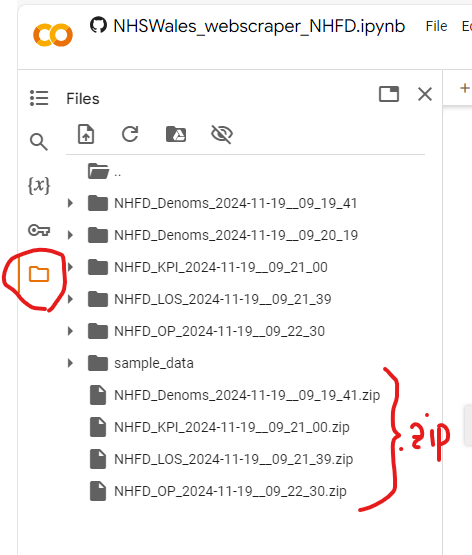

- Click on the three dots on the to the right of each zipped folder.

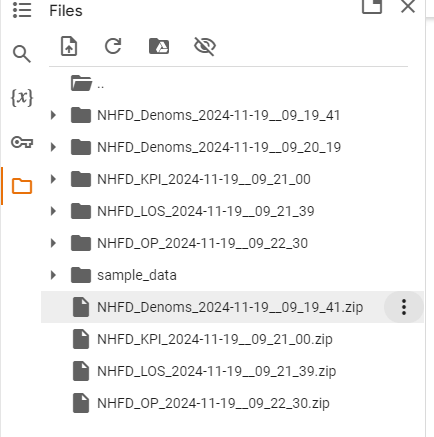

- Click on download and you will find them in your Download folder.

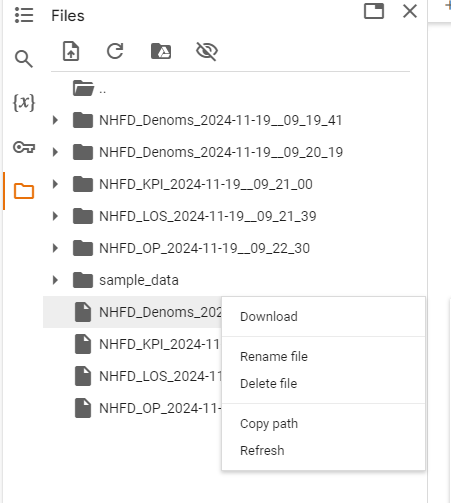

- If you do not download the zipped folders before closing the notebook, you will lose the work and you will need to re-run the notebook from the start to regenerate the files.